# Stage 1 - First experimentations  
### The goal of this notebook is to train basics models on our clean dataset. First we'll import the data cleaned from our EDA/pre-processing notebook, then we'll make the train/test split & manage the scale and balance issues after the split to prevent any form of data leakage. Then we'll try to fit some models and tune them with the best set of hyperparameters using gridsearch with cross-validation, finally we'll analyse them to check their performances & to ensure that they don't overfit.

# 0. Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, fbeta_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold


# 1. Import the data

In [4]:
cleaned_data = pd.read_csv('cleaned_data.csv', sep=',')
cleaned_data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,0,0,0
1,10.829943,0.175592,1.294219,0,0,0,0
2,5.091079,0.805153,0.427715,0,0,1,0
3,2.247564,5.600044,0.362663,1,0,1,0
4,44.190936,0.566486,2.222767,1,0,1,0


# 2. Split the data

In [5]:
X = cleaned_data.drop(columns=['fraud'])
y = cleaned_data['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Outlier function remover

In [ ]:
def remove_outliers_zscore(data, columns, threshold=3):
    """
    Removes outliers from the specified columns using the Z-score method.

    Parameters:
    - data : pandas DataFrame
        The input DataFrame containing the data.
    - columns : list
        List of numeric columns to check for outliers.
    - threshold : float, optional (default: 3)
        The Z-score threshold to identify outliers. Values above this threshold
        (or below -threshold) will be considered as outliers.

    Returns:
    - DataFrame : A new DataFrame with outliers removed.
    """
    df = data.copy() # we create a copy of the input DataFrame to prevent memory issues

    for col in columns:
        df['zscore'] = zscore(df[col])
        df = df[(df['zscore'].abs() < threshold)]

    df = df.drop(columns=['zscore'])
    return df

# 3. Remove outliers only from the training set

We remove outliers before applying SMOTE to ensures that synthetic samples are generated based on typical data, not extreme values. This prevents SMOTE from creating unrealistic points, reduces the risk of model overfitting, and maintains data quality, leading to better and more reliable predictions.

In [ ]:
columns_to_check = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] # we of course only care about non-categorical columns as categorical columns cannot have outliers.
X_train_clean = remove_outliers_zscore(X_train, columns_to_check)
y_train_clean = y_train.loc[X_train_clean.index] # we need to make sure to only keep the labels corresponding to the cleaned data

# 4. Apply SMOTE on the cleaned training set

### We use SMOTE (Synthetic Minority Oversampling Technique) to address class imbalance in our data. It works by creating synthetic samples for the minority class (fraud) through interpolation between existing samples. This helps balance the dataset, improving model performance and reducing bias toward the majority class. SMOTE is widely used when the minority class is underrepresented, leading to better generalization and fairer predictions.

In [8]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train_clean)

# 5. Standardize the features

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) # we only transform the test data, we do not fit the scaler again to avoid data leakage.

In [ ]:
print(f"Shape of X_train_clean: {X_train_clean.shape}")
print(f"Shape of y_train_clean: {y_train_clean.shape}")
print(f"Shape of X_train_resampled: {X_train_resampled.shape}")
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")
# Just to make sure that the shape of the data is as expected.

Shape of X_train_clean: (770889, 6)
Shape of y_train_clean: (770889,)
Shape of X_train_resampled: (1433024, 6)
Shape of y_train_resampled: (1433024,)


# Define the F2 scorer

We chose the F2-score over accuracy because it better aligns with the goals of fraud detection: F2 = (1 + 2²) · (Precision · Recall) / ((2² · Precision) + Recall)

- Emphasis on Recall:

    - In fraud detection, it's crucial to minimize the number of missed fraudulent transactions (false negatives).
    - The F2-score gives twice as much importance to recall compared to precision, ensuring that the model prioritizes detecting as many frauds as possible, even at the cost of a few extra false alarms.

- Handling Imbalanced Data:

    - Accuracy can be misleading with imbalanced datasets, where non-fraudulent transactions dominate.
    - The F2-score focuses on the performance of the minority class (fraudulent transactions), providing a more realistic evaluation of the model's ability to detect fraud.
    - (even if we have synthetically balanced our dataset using SMOTE, this approach may change over the time, therefore we still prefer to use the f2-score as our key metrics)

- Better Fit for Business Objectives:

    - In real-world scenarios, missing a fraudulent transaction can be far more costly than mistakenly flagging a legitimate one.
    - The F2-score helps us prioritize catching fraudulent transactions, which is key for reducing financial losses.

In [16]:
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the parameter grid for the LogisticRegression

In [18]:
param_grid_logistic = [
    {
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['saga'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.0, 0.5, 1.0]  # Only used for elasticnet
    }
]

# GridSearchCV configuration

In [19]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # we use stratified k-fold to ensure that the class distribution is preserved in each fold, five splits must be enough to get a good estimate of the model's performance.

grid_search_logistic = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=500), # we set a random state to ensure reproducibility
    param_grid=param_grid_logistic,
    scoring=f2_scorer, # we use the custom f2 scorer
    cv=stratified_cv,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
    )

# Train the Grid Search on resampled and scaled data

In [20]:
grid_search_logistic.fit(X_train_scaled, y_train_resampled)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=LogisticRegression(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'sag']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.0, 0.5, 1.0],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2),
             verbose=2)

# Extract the best model found by Grid Search

In [21]:
best_model_Logistic = grid_search_logistic.best_estimator_

# Display the best parameters and the best score

In [ ]:
print("Best parameters found for LogisticalRegression:", grid_search_logistic.best_params_)
print("Best F2-score for LogisticalRegression:", grid_search_logistic.best_score_)
# It seems that the best results for linear models are obtained with the 'liblinear' solver, which is the default solver for LogisticRegression, the penalty term is l2 which correspond to the Ridge Regression.

Best parameters found for LogisticalRegression: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best F2-score for LogisticalRegression: 0.9605024757590263


# Predictions on the test set

In [23]:
# Predict classes on the test set for the confusiion matrix and classification report
y_pred_Logistic = best_model_Logistic.predict(X_test_scaled)

# Predict probabilities of the positive class for the ROC curve
y_probs_Logistic = best_model_Logistic.predict_proba(X_test_scaled)[:, 1]


# Display the Confusion Matrix & Classification report

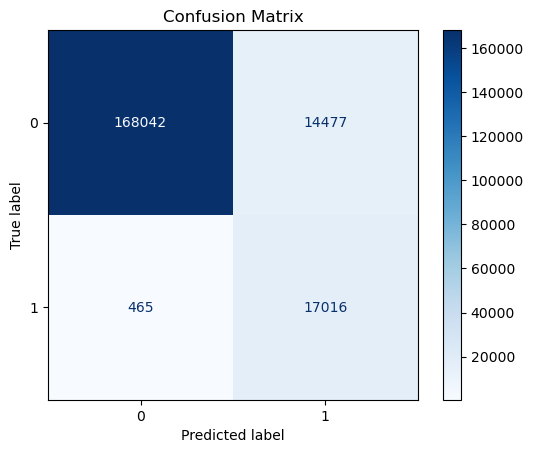

In [24]:
cm_Logistic = confusion_matrix(y_test, y_pred_Logistic)
classification_report_Logistic = classification_report(y_test, y_pred_Logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_Logistic)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [25]:
print(classification_report_Logistic)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96    182519
           1       0.54      0.97      0.69     17481

    accuracy                           0.93    200000
   macro avg       0.77      0.95      0.83    200000
weighted avg       0.96      0.93      0.93    200000



The model has a very strong recall on the minority class which is exactly the goal that we wanted to reach as it translates a minimization of False Negative (the actual frauds that were not detected) that we absolutely want to avoid in fraud detection. The precision is lower for the minority class (0.54) which pretty acceptable in our use case as we are ready to accept predict a bit more of false positive to avoid missing on actual fraudulents transactions. The model performances matche our excpectations, we made the right choice by choosing the F2 score to drive our grid search !

# Plot the ROC curve

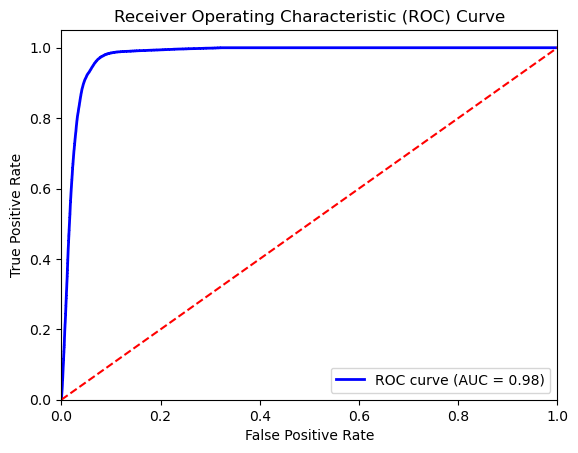

In [26]:
# Calculate the ROC curve and AUC
fpr_Logisitic, tpr_Logisitic, _ = roc_curve(y_test, y_probs_Logistic)
roc_auc_Logisitic = auc(fpr_Logisitic, tpr_Logisitic)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_Logisitic, tpr_Logisitic, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_Logisitic:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The AUC (Area Under the Curve) is very close to 1 (0.98) which reveal an almost perfect ability to distinguish between classes. Moreover, the ROC curve is very close to the top left corner which mean that the model has good balance between False Positive Rate & True Positive Rate.

# Overfitting Analysis for Logistic Regression

c:\Users\Gabriel\anaconda3\envs\DIABasics\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabriel\anaconda3\envs\DIABasics\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabriel\anaconda3\envs\DIABasics\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gabriel\anaconda3\envs\DIABasics\Lib\site-packages\sk

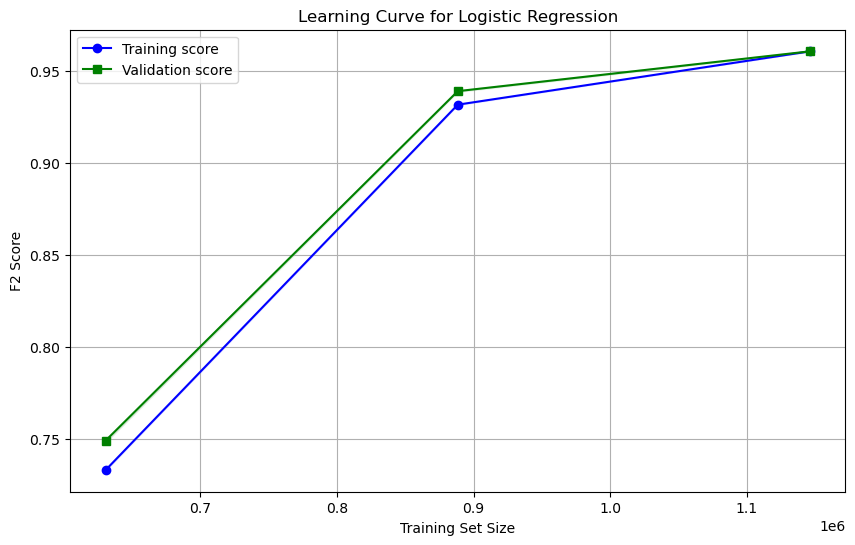

In [27]:
# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model_Logistic,
    X_train_scaled,
    y_train_resampled,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1
)

# Calculate the mean and standard deviation for the training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, val_mean, label='Validation score', color='green', marker='s')

# Add the confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.1)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('F2 Score')
plt.title('Learning Curve for Logistic Regression')
plt.legend(loc='best')
plt.grid()
plt.show()

- The Logistic Regression model does not show signs of overfitting because:

    - No perfect training score: The training F2-score is below 1.0, indicating the model does not fit the training data perfectly.
    - Small gap between training and validation scores: The validation score is close to the training score, suggesting good generalization.
    - Consistent increase in scores: Both training and validation scores improve with more data, showing that the model continues to learn effectively without overfitting.
- Overall, the model demonstrates balanced learning and strong generalization.

# Use of the KNN Model 

Using KNN after logistic regression in a fraud detection problem is justified by its ability to capture local patterns in the data that the logistic regression model might overlook. Logistic regression is a linear model and may struggle with complex decision boundaries. KNN, being a non-parametric and instance-based algorithm, leverages proximity to make predictions, which can complement logistic regression by identifying subtle patterns in the minority class. This combination helps improve precision, which our logistic regression model was struggling with, while maintaining a strong recall. The use of the KNN should increase the F2 score, highlighting the improved balance between precision and recall, aligning with the goal to spot the maximum of fraudulent transactions without overpredicting the False Positive even if we can allow ourselves a certain percentage of them.

# Define the parameter grid for the KNN

In [28]:
# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Configure GridSearchCV for KNN
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    scoring=f2_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

# Train the Grid Search on resampled and scaled data
grid_search_knn.fit(X_train_scaled, y_train_resampled)

# Extract the best model found by Grid Search
best_model_knn = grid_search_knn.best_estimator_

# Display the best parameters and the best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best F2-score for KNN:", grid_search_knn.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best F2-score for KNN: 0.9992266435529034


In [29]:
# Predict classes on the test set
y_pred_knn = best_model_knn.predict(X_test_scaled)

# Predict probabilities of the positive class for the ROC curve
y_probs_knn = best_model_knn.predict_proba(X_test_scaled)[:, 1]


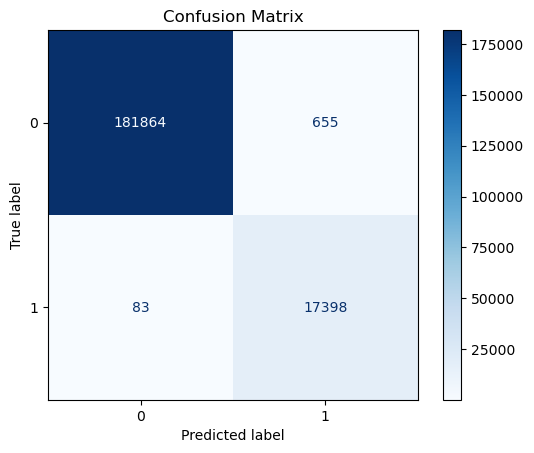

In [30]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
classification_report_KNN = classification_report(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
print(classification_report_KNN)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    182519
           1       0.96      1.00      0.98     17481

    accuracy                           1.00    200000
   macro avg       0.98      1.00      0.99    200000
weighted avg       1.00      1.00      1.00    200000



We obtain exceptionnal results with KNN model, it is not actually surprising considering the quality of the dataset but we'll still try to improve those results ! The recall score are optimal for both classes, our only progression axis is maybe to reduce our False Positive rate in a business objective as it is still lowering the precision but let's be honest it's a detail.

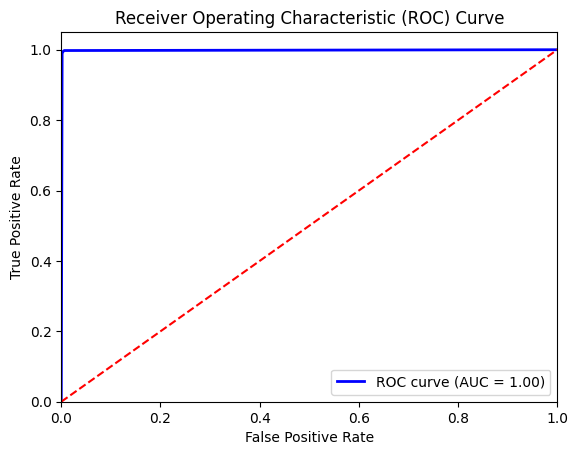

In [25]:
# Calculate the ROC curve and AUC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_knn)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The ROC-AUC analysis is almost perfect, the ROC curve almost forms a right angle and the AUC is equal to 1 which the maximum (we know that it's not exactly 1 because of the rounding but we're extremely close)

# Overfitting Analysis

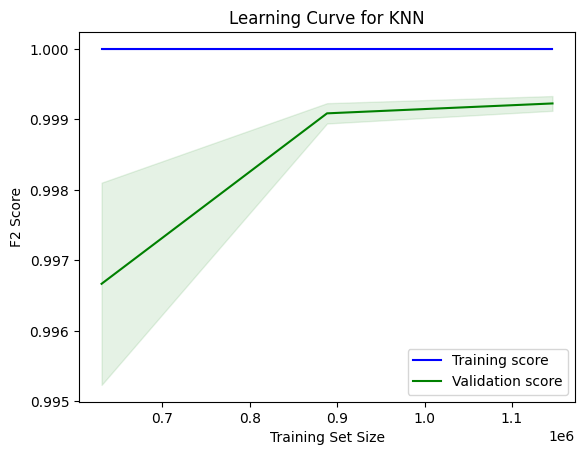

In [27]:
# Compute learning curves
train_sizes, train_scores, val_scores = learning_curve(
    grid_search_knn.best_estimator_, 
    X_train_scaled, 
    y_train_resampled,
    cv=5, 
    scoring=f2_scorer, 
    _jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation score', color='green')

# Add confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('F2 Score')
plt.title('Learning Curve for KNN')
plt.legend(loc='best')
plt.show()


Overfitting Analysis

- Observations:
    - The training F2-score is perfect (1.0), indicating the model learned the training data flawlessly.
    - The validation F2-score is slightly lower (~0.998), but the gap is minimal, suggesting good generalization on the validation set.
- Conclusion:
    - There is no clear sign of overfitting based on the current validation results, as the training and validation scores are very close.
    - However, the perfect training score may hint at potential overfitting. Testing on an independent dataset is recommended for confirmation, we'll double-check.

# Double checking 

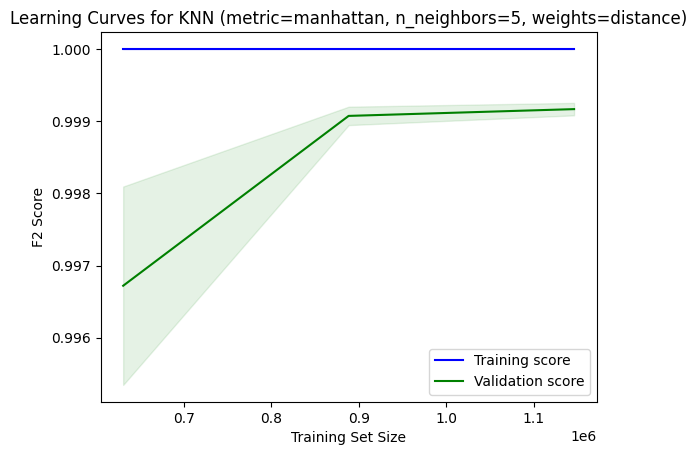

In [28]:
knn_model_checking = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

knn_model_checking.fit(X_train_scaled, y_train_resampled)

train_sizes, train_scores, val_scores = learning_curve(
    knn_model_checking, 
    X_train_scaled, 
    y_train_resampled,
    cv=5, 
    scoring=f2_scorer, 
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, val_mean, label='Validation score', color='green')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.1)

plt.xlabel('Training Set Size')
plt.ylabel('F2 Score')
plt.title('Learning Curves for KNN (metric=manhattan, n_neighbors=5, weights=distance)')
plt.legend(loc='best')
plt.show()

- Based on the similar learning curves for both n_neighbors = 3 and n_neighbors = 5, the risk of overfitting is low because:
    - Minimal gap between training and validation scores, indicating good generalization.
    - Consistent performance across different values of n_neighbors, suggesting model stability.
    - High validation scores, close to training scores, showing that the model is not overly fitted to the training data.
    
- Overall, the model demonstrates robust generalization with a low likelihood of overfitting.

#### This concludes our Stage 1, where we obtained excellent results with the KNN model. Empirically, we know that tree-based models perform better for classification problems. In the next stage, we'll aim to improve our results using Random Forest and XGBoost, for instance. Since decision trees are much less sensitive to imbalanced datasets, we may explore other approaches beyond SMOTE!